# Sextortion Investigation Demo

In this demo we will investigate Bitcoin addresses that received money from Sextortion Spam victims. The data from this demo is taken from our study [Spams meet Cryptocurrencies: Sextortion in the Bitcoin Ecosystem](https://arxiv.org/abs/1908.01051) and is a subset of [all the 12,533 Bitcoin addresses](https://github.com/MatteoRomiti/Sextortion_Spam_Bitcoin) we have collected from 4,340,736 sextortion spam emails.

The data for this demo is available in `./examples/data/sextortion_addresses.json`

We are going to answer the following questions:

* Q1: How many USD did the input addresses receive in total?

* Q2: How many USD did the corresponding entities receive in total?

* Q3: How many addresses are controlled by these entities?

* Q4: Where did the money come from, where did it go to?

* Q5: Can we find any known entities (e.g., exchanges) in the digital money trace?

## Preparations

First, we install the graphsense-python package as described in the [README](https://github.com/graphsense/graphsense-python/blob/develop/README.md) of this repository. Import the package and configure the API endpoint. An API key for the public GraphSense demo API can be requested by sending an email to contact@graphense.info.

In [1]:
import graphsense

from pprint import pprint

configuration = graphsense.Configuration(
    host = "https://api.graphsense.info/",
    api_key = {'api_key': 'REPLACE_WITH_API_KEY'})

We can test whether or client works, by checking what data the GraphSense endpoint provides

In [2]:
with graphsense.ApiClient(configuration) as api_client:
    general_api = graphsense.GeneralApi(api_client)
    api_response = general_api.get_statistics()
    pprint(api_response.version)

{'file': '0.4.5',
 'hash': None,
 'nr': '0.4.5',
 'timestamp': '2021-04-30 10:39:30'}


Now we load the provided sample Bitcoin addresses


In [3]:
import json

INPUT_FILE = './data/sextortion_addresses.json' # 245 sextortion addresses
with open(INPUT_FILE, 'r') as fp:
    input_addresses = json.load(fp)
    
pprint(f"Example address: {input_addresses[0]}")
print(f"Total number of addresses: {len(input_addresses)}")

'Example address: 1JwRp2J8bQcoG8XTUbxQZaEj9QB4RB6zEa'
Total number of addresses: 245


# Q1. How many USD (US dollars) did the input addresses receive in total?

GraphSenes supports several asset types: Bitcoin (BTC), Bitcoin Cash (BCH), Litecoin (LTC), ZCash (ZEC).

We are investigating Bitcoin transactions, therefore we set the default currency to Bitcoin **BTC**.

In [4]:
CURRENCY = 'btc'

In [5]:
address_details = dict()  # here we store data for each address

with graphsense.ApiClient(configuration) as api_client:
    addresses_api = graphsense.AddressesApi(api_client)
    for i, a in enumerate(input_addresses):
        print(i + 1, end='\r')
        address_details[a] = addresses_api.get_address_with_tags(CURRENCY, a)

In [6]:
total_received = sum([el.total_received.usd for el in address_details.values()])
print("{} addresses received {:,.2f} USD".format(len(address_details), total_received))

245 addresses received 880,192.00 USD


# Q2: How many USD did the corresponding entities receive in total?
# Q3: How many addresses are controlled by these entities?

For each address, fetch the corresponding entity and store it in a dict for further use

In [7]:
address_entity = dict()  # address, entity_id
entities = dict()  # entity_id, details (for later)

with graphsense.ApiClient(configuration) as api_client:
    addresses_api = graphsense.AddressesApi(api_client)
    for i, a in enumerate(input_addresses):
        print(i + 1, end='\r')
        e = addresses_api.get_address_entity(CURRENCY, a)
        address_entity[a] = e.entity
        entities[e.entity] = e

For each entity, fetch all addresses controlled by that entity

In [8]:
entity_addresses = dict()  # entity_id, list of addresses with details

with graphsense.ApiClient(configuration) as api_client:
    entities_api = graphsense.EntitiesApi(api_client)
    for i, e in enumerate(address_entity.values()):
        print(i + 1, end='\r')
        if e not in entity_addresses:
            entity_addresses[e] = entities_api.list_entity_addresses(CURRENCY, e)


Count the number of retrieved entities, the number of addresses controlled by these entities, and sum up the total number of USD received by these entities

In [9]:
n_addresses = 0
usd_in = 0
for v in entities:
    n_addresses += entities[v].no_addresses
    usd_in += entities[v].total_received.usd

print("{} entities with {:,.0f} addresses received {:,.0f} USD".format(len(entities), n_addresses, usd_in))

96 entities with 1,839,374 addresses received 10,516,452,271 USD


Investigate these entities by plotting a histogram.

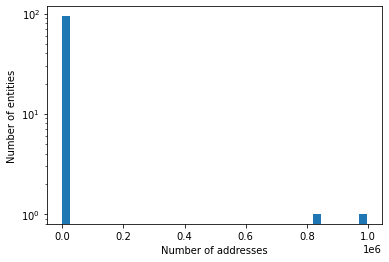

In [10]:
import matplotlib.pyplot as plt

#no_addresses_in_entities = [e for e in entities]
#no_addresses_in_entities

no_entity_addresses = [entity.no_addresses for entity in entities.values()]
plt.hist(no_entity_addresses, bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of addresses')
plt.yscale('log')
plt.show()

We can assume that entities with very large number of addresses are services (e.g., exchanges) or super-clusters. Therefore, for our further analysis, we filter our entities by **ignoring entities with more than 10K address**.

In [11]:
filtered_entities = [entity for entity in entities.values() if entity.no_addresses < 10000]
len(filtered_entities)

n_addresses = 0
usd_in = 0
for entity in filtered_entities:
    n_addresses += entity.no_addresses
    usd_in += entity.total_received.usd
    
print("{} entities with {:,.0f} addresses received {:,.0f} USD"
      .format(len(filtered_entities), n_addresses, usd_in))

94 entities with 562 addresses received 1,504,175 USD


# Q4: Where did the money come from, where did it go to?

For all filtered entities we now gather all incoming and outgoing entities.

In [13]:
entity_nbrs_in = dict()
entity_nbrs_out = dict()

with graphsense.ApiClient(configuration) as api_client:
    entities_api = graphsense.EntitiesApi(api_client)
    for i, e in enumerate(filtered_entities):
        print(i+1, end='\r')
        if e.entity not in entity_nbrs_in:
            entity_nbrs_in[e.entity] = entities_api.list_entity_neighbors(CURRENCY, e.entity, 'in')
        if e.entity not in entity_nbrs_out:
            entity_nbrs_out[e.entity] = entities_api.list_entity_neighbors(CURRENCY, e.entity, 'out')

To get an overview, we count the number of incoming and outgoing entities

In [14]:
no_incoming_entities = {key:len(entity_nbrs_in[key].neighbors) for key in entity_nbrs_in}

no_outgoing_entities = {key:len(entity_nbrs_out[key].neighbors) for key in entity_nbrs_out}

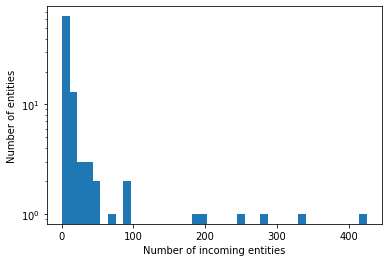

In [15]:
plt.hist(no_incoming_entities.values(), bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of incoming entities')
plt.yscale('log')
plt.show()

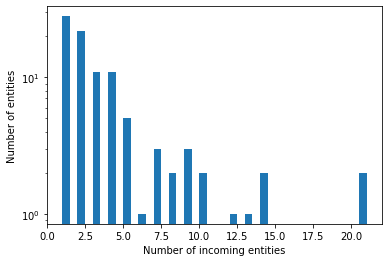

In [16]:
plt.hist(no_outgoing_entities.values(), bins = 40)
plt.ylabel('Number of entities')
plt.xlabel('Number of incoming entities')
plt.yscale('log')
plt.show()

To see where the money **came from**, we aggregate, for each entity, the IDs and labels of the incoming and outgoing entities.

In [17]:
incoming_entities = {}

for entity_id, n in entity_nbrs_in.items():
    neighbors = []
    for neighbor in n.neighbors:
        neighbor_id = neighbor.id
        neighbor_labels = neighbor.labels
        neighbors.append({'id': neighbor_id,
                          'labels': neighbor_labels})
    incoming_entities[entity_id] = neighbors

To see where the money **went to**, we aggregate, for each entity, the IDs and labels of the incoming and outgoing entities.

In [18]:
outgoing_entities = {}

for entity_id, n in entity_nbrs_out.items():
    neighbors = []
    for neighbor in n.neighbors:
        neighbor_id = neighbor.id
        neighbor_labels = neighbor.labels
        neighbors.append({'id': neighbor_id,
                          'labels': neighbor_labels})
    outgoing_entities[entity_id] = neighbors

## Q5: Can we find any known entities (e.g., exchanges) in the digital money trace?

In [19]:
incoming_labels = []

for entities in incoming_entities.values():
    for entity in entities:
        for label in entity['labels']:
            incoming_labels.append(label)
            
print(set(incoming_labels))


{'bittoclick', 'kraken', 'jaredkaragen', 'natasha', 'poloniex', 'binance', 'Shapeshift', 'okex', 'battlesrc bitcoin', 'bitcoinbon.at - Unique sending out address', 'bitstamp', 'bittrex', 'Sextortion Spam', 'therocktrading.com', 'wegfan no.2', 'coin academy', 'Yinyin Tian Lazarus Group', 'xapo', 'bitfinex', 'bitcoincopy.site123.me', 'pirate party of austria', 'cryptonator', 'kurph', 'coincafe.com', 'Shapeshift User 25', '7pool', 'karlzt', 'hyip monitor investspot', 'k.a.t', 'Jiadong Li', 'btc.com', 'trinick', 'huobi mining pool', 'huobi.com', 'cubits.com', 'bixin', 'binance hack', 'cryptopay.me', 'c01nc3', 'okpool.top', 'bitpanda', 'crypt', 'www.investspot.biz', 'virwox.com', 'bitcoin.de', 'coinbase', 'haobtc.com'}


In [20]:
outgoing_labels = []

for entities in outgoing_entities.values():
    for entity in entities:
        for label in entity['labels']:
            outgoing_labels.append(label)
            
print(set(outgoing_labels))


{'binance hack', 'cryptonator', 'okpool.top', 'Jiadong Li', 'okex', 'Sextortion Spam'}


## Network Visualization

Finally, we build and visualize a network showing the entities we just identified and collected.

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

### Entities sending money to sextortion addresses

In [22]:
g = nx.DiGraph()
for (entity, neighbors) in incoming_entities.items():
    for neighbor in neighbors:
        if (len(neighbor['labels']) > 0):
            g.add_edge(neighbor['id'], entity)
            g.add_node(entity, label='sextortion')
            g.add_node(neighbor['id'], label=neighbor['labels'][0])            

In [23]:
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")

Number of nodes: 110
Number of edges: 196


In [24]:
node_colours = []

for node_id, values in list(g.nodes(data=True)):
    if(values['label'] == 'sextortion'):
        node_colours.append('red')
    else:
        node_colours.append('green')

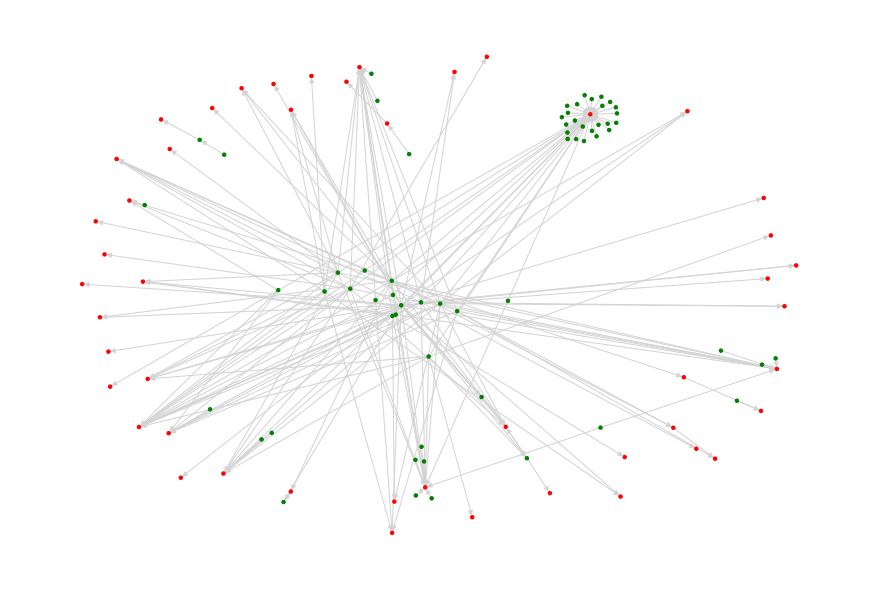

In [25]:
pos = nx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12, 8))
plt.title.text = "Known entities sending money to addresses involved in sexytortion spam."
nx.draw(g, 
        edge_color='lightgrey',
        node_color=node_colours,
        node_size=12,
        pos=pos)


### Entities receiving money from sextortion addresses

In [26]:
g = nx.DiGraph()
for (entity, neighbors) in outgoing_entities.items():
    for neighbor in neighbors:
        if (len(neighbor['labels']) > 0):
            g.add_edge(entity, neighbor['id'])
            g.add_node(entity, label='sextortion')
            g.add_node(neighbor['id'], label=neighbor['labels'][0])            

In [27]:
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")

Number of nodes: 33
Number of edges: 24


In [28]:
node_colours = []
label_dict = {}

for node_id, values in list(g.nodes(data=True)):
    if(values['label'] == 'sextortion'):
        node_colours.append('red')
    else:
        node_colours.append('green')
        label_dict[node_id] = node_id

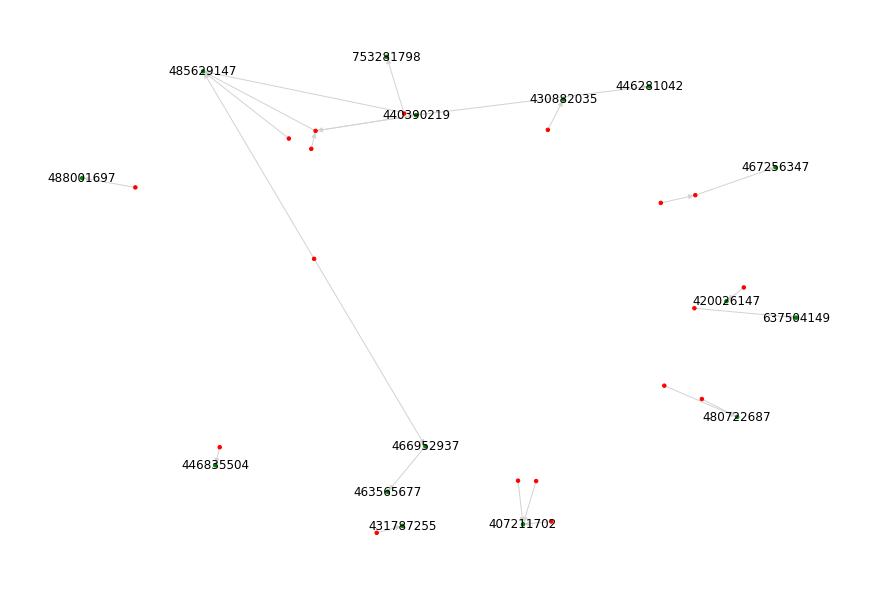

In [29]:
pos = nx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12, 8))
plt.title.text = "Known entities sending money to addresses involved in sexytortion spam."
nx.draw(g, 
        edge_color='lightgrey',
        node_color=node_colours,
        node_size=12,
        labels=label_dict,
        with_labels=True,
        pos=pos)
